In [1]:
import heapq

class Event:
    '''
    Store the properties of one event in the Schedule class defined below. Each
    event has a time at which it needs to run, a function to call when running
    the event, along with the arguments and keyword arguments to pass to that
    function.
    '''
    def __init__(self, timestamp, function, *args, **kwargs):
        self.timestamp = timestamp
        self.function = function
        self.args = args
        self.kwargs = kwargs

    def __lt__(self, other):
        '''
        This overloads the less-than operator in Python. We need it so the
        priority queue knows how to compare two events. We want events with
        earlier (smaller) times to go first.
        '''
        return self.timestamp < other.timestamp

    def run(self, schedule):
        '''
        Run an event by calling the function with its arguments and keyword
        arguments. The first argument to any event function is always the
        schedule in which events are being tracked. The schedule object can be
        used to add new events to the priority queue.
        '''
        self.function(schedule, *self.args, **self.kwargs)


class Schedule:
    '''
    Implement an event schedule using a priority queue. You can add events and
    run the next event.
    
    The `now` attribute contains the time at which the last event was run.
    '''
    
    def __init__(self):
        self.now = 0  # Keep track of the current simulation time
        self.priority_queue = []  # The priority queue of events to run
    
    def add_event_at(self, timestamp, function, *args, **kwargs):
        # Add an event to the schedule at a particular point in time.
        heapq.heappush(
            self.priority_queue,
            Event(timestamp, function, *args, **kwargs))
    
    def add_event_after(self, interval, function, *args, **kwargs):
        # Add an event to the schedule after a specified time interval.
        self.add_event_at(self.now + interval, function, *args, **kwargs)
    
    def next_event_time(self):
        return self.priority_queue[0].timestamp

    def run_next_event(self):
        # Get the next event from the priority queue and run it.
        event = heapq.heappop(self.priority_queue)
        self.now = event.timestamp
        event.run(self)
        
    def __repr__(self):
        return (
            f'Schedule() at time {self.now} ' +
            f'with {len(self.priority_queue)} events in the queue')
    
    def print_events(self):
        print(repr(self))
        for event in sorted(self.priority_queue):
            print(f'   {event.timestamp}: {event.function.__name__}')


In [2]:
# M/D/1 queue

import scipy.stats as sts


class Queue:
    def __init__(self, service_rate):
        # Store the deterministic service time for an M/D/1 queue
        self.service_time = 1 / service_rate
        # We start with an empty queue and the server not busy
        self.people_in_queue = 0
        self.people_being_served = 0

    def add_customer(self, schedule):
        # Add the customer to the queue
        self.people_in_queue += 1
        if self.people_being_served < 1:
            # This customer can be served immediately
            schedule.add_event_after(0, self.start_serving_customer)
            
    def start_serving_customer(self, schedule):
        # Move the customer from the queue to a server
        self.people_in_queue -= 1
        self.people_being_served += 1
        # Schedule when the server will be done with the customer
        schedule.add_event_after(
            self.service_time,
            self.finish_serving_customer)
            
    def finish_serving_customer(self, schedule):
        # Remove the customer from the server
        self.people_being_served -= 1
        if self.people_in_queue > 0:
            # There are more people in the queue so serve the next customer
            schedule.add_event_after(0, self.start_serving_customer)


class BusSystem:
    
    def __init__(self, arrival_rate, service_rate):
        self.queue = Queue(service_rate)
        self.arrival_distribution = sts.expon(scale=1/arrival_rate)

    def add_customer(self, schedule):
        # Add this customer to the queue
        self.queue.add_customer(schedule)
        # Schedule when to add another customer
        schedule.add_event_after(
            self.arrival_distribution.rvs(),
            self.add_customer)

    def run(self, schedule):
        # Schedule when the first customer arrives
        schedule.add_event_after(
            self.arrival_distribution.rvs(),
            self.add_customer)
        

def run_simulation(arrival_rate, service_rate, run_until):
    schedule = Schedule()
    bus_system = BusSystem(arrival_rate, service_rate)
    bus_system.run(schedule)
    while schedule.next_event_time() < run_until:
        schedule.run_next_event()
    return bus_system

In [3]:
# Run a short test
bus_system = run_simulation(arrival_rate=0.8, service_rate=1, run_until=100)
print(f'There are {bus_system.queue.people_in_queue} people in the queue')

There are 4 people in the queue


mean:  1.52
conf int:  [1.113 1.927]


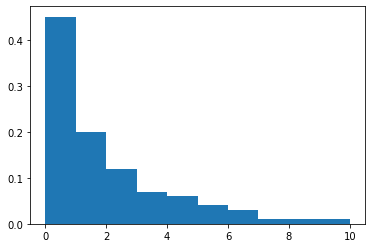

In [18]:
import matplotlib.pyplot as plt
import numpy as np, scipy.stats as st

res=[]  #array to store results
for _ in range(100):  #run 100 times
    bus_system = run_simulation(arrival_rate=0.8, service_rate=1, run_until=100)  #run sim
    res.append(bus_system.queue.people_in_queue) #get the values

print("mean: ", np.mean(res))  #take the mean
print("conf int: ", np.round((st.t.interval(0.95, len(res)-1, loc=np.mean(res), scale=st.sem(res))),decimals=3)) #take 95% conf int

plt.hist(res, density=True) #histogram
plt.show()


mean:  1.537
conf int:  [1.401 1.673]


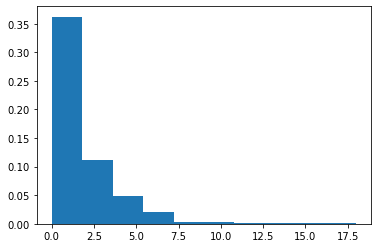

In [17]:
#same thing for 1000 runs
res=[]  
for _ in range(1000):
    bus_system = run_simulation(arrival_rate=0.8, service_rate=1, run_until=100)
    res.append(bus_system.queue.people_in_queue)

print("mean: ", np.mean(res))
print("conf int: ", np.round(st.t.interval(0.95, len(res)-1, loc=np.mean(res), scale=st.sem(res)),decimals=3))

plt.hist(res, density=True)
plt.show()

The histograms look similar and the mean as well. However the conf int is tighter on the second one.

In [31]:
Res = []  #array to store mean results
up = []  #array to store upper conf int results
down = [] #array to store lower conf int results
x = [j/100 for j in range(80, 120)]  #arrival rates to try

for i in x:  #itertate through the arrival rates
    #same thing as last code cells
    res=[]
    for _ in range(100):
        bus_system = run_simulation(arrival_rate=i, service_rate=1, run_until=100)
        res.append(bus_system.queue.people_in_queue)

    conf = np.round(st.t.interval(0.95, len(res)-1, loc=np.mean(res), scale=st.sem(res)),decimals=3) #take conf int
    down.append(conf[0]) 
    up.append(conf[1])
    Res.append(np.mean(res))

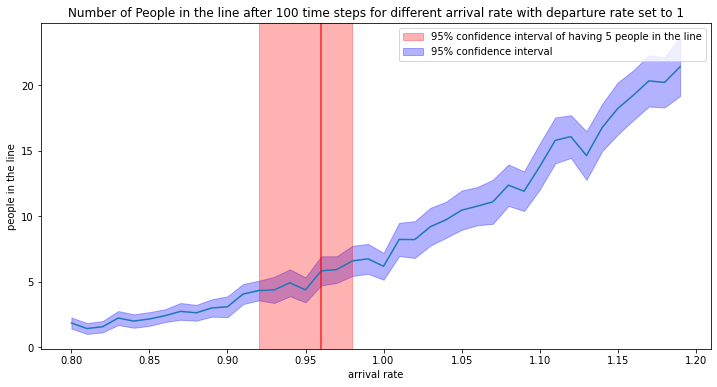

In [39]:
plt.figure(figsize=(12, 6))
plt.plot(x, Res)  #mean
plt.fill_between(x, up, down, color='blue', alpha=0.3, label='95% confidence interval') #conf int


#getting the x coordinate for where it hits 5 for up and low conf int, and mean
up_ind = 0
for i,j in enumerate(up):
    if j>5:
        up_ind=i
        break

low_ind = 0
for i,j in enumerate(down):
    if j>5:
        low_ind=i
        break

mean_ind=0
for i,j in enumerate(Res):
    if j>5:
        mean_ind=i
        break
    

plt.axvline(x[mean_ind], color='red', alpha=0.8)
plt.axvspan(x[low_ind], x[up_ind], alpha=0.3, color='red', label='95% confidence interval of having 5 people in the line')
plt.xlabel('arrival rate')
plt.ylabel('people in the line')
plt.legend()
plt.title('Number of People in the line after 100 time steps for different arrival rate with departure rate set to 1')
plt.show()


#EmpiricalAnalysis - The results are nicelly summarized and put in a very nice looking plot for easy vizualization. The statistics are done just like asked for in the problem, and the simulation is running multiple times for each condition, taking both mean and conf int for comparison. 

#Professionalism - The vizualization follows the correct guideliness, including title, legend and named axis. The python notebook is well organized and the code is commented and easy to understand